# March Machine Learning Mania
In this notebook, we perform EDA and aggregate statistics on the provided __compact data__ via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2025/overview).

In [1]:
from helper import *

# calculate number of unique bracket combinations
num_brackets = 2 ** 63 # number of games in a 64 team bracket
format(num_brackets, ',d')

'9,223,372,036,854,775,808'

There are over __9 quintillion__ possible March Madness brackets.

In [2]:
# how many unique brackets would each person on earth have to fill out to reach this number?
world_pop = 8100000000
brackets_per_person = num_brackets / world_pop
format(brackets_per_person, ',.0f')

'1,138,687,906'

Every person on Earth would have to create over __1 billion__ brackets in order for us to definitively generate the "perfect" bracket.

# Import Data

In [3]:
# reg season results
reg_results = pd.concat([pd.read_csv(MENS_ROOT + 'MRegularSeasonCompactResults.csv'), pd.read_csv(WOMENS_ROOT + 'WRegularSeasonCompactResults.csv')], ignore_index=True)

# historical tourney results
tourney_results = pd.concat([pd.read_csv(MENS_ROOT + 'MNCAATourneyCompactResults.csv'), pd.read_csv(WOMENS_ROOT + 'WNCAATourneyCompactResults.csv')], ignore_index=True)

# historical seeds
seeds =  pd.concat([pd.read_csv(MENS_ROOT + 'MNCAATourneySeeds.csv'), pd.read_csv(WOMENS_ROOT + 'WNCAATourneySeeds.csv')], ignore_index=True)

# conference tournament
conf_games = pd.read_csv(MENS_ROOT + 'MConferenceTourneyGames.csv')

# dataset names
names = ['Regular Season Results', 'Tourney Results', 'Seeds', 'Conference Tournament']

# iterate through datasets
for data, name in zip([reg_results, tourney_results, seeds, conf_games], names):
    # print name
    print(name)

    # show shape and nulls
    show_shape_and_nulls(data, nulls_view='print')
    print()

Regular Season Results
Shape: (329958, 8)
Null values:
Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

Tourney Results
Shape: (4168, 8)
Null values:
Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

Seeds
Shape: (4370, 3)
Null values:
Season    0
Seed      0
TeamID    0
dtype: int64

Conference Tournament
Shape: (6793, 5)
Null values:
Season        0
ConfAbbrev    0
DayNum        0
WTeamID       0
LTeamID       0
dtype: int64



- No nulls.
- Almost __330K__ regular season games.
- Over __4000__ NCAA Tournament games.

In [4]:
# iterate through datasets
for data, name in zip([reg_results, tourney_results, seeds, conf_games], names):
    # print name
    print(name)

    # show unique values
    show_unique_vals(data)
    print('#---------------------------#', end='\n\n')

Regular Season Results
"Season" has 41 unique values

"DayNum" has 133 unique values

"WTeamID" has 749 unique values

"WScore" has 132 unique values

"LTeamID" has 749 unique values

"LScore" has 126 unique values

"WLoc" has 3 unique values
['N' 'H' 'A']

"NumOT" has 7 unique values
[0 3 1 2 4 5 6]

#---------------------------#

Tourney Results
"Season" has 39 unique values

"DayNum" has 20 unique values

"WTeamID" has 349 unique values

"WScore" has 80 unique values

"LTeamID" has 588 unique values

"LScore" has 80 unique values

"WLoc" has 3 unique values
['N' 'H' 'A']

"NumOT" has 4 unique values
[0 1 3 2]

#---------------------------#

Seeds
"Season" has 40 unique values

"Seed" has 96 unique values

"TeamID" has 598 unique values

#---------------------------#

Conference Tournament
"Season" has 25 unique values

"ConfAbbrev" has 36 unique values

"DayNum" has 17 unique values
[121 122 123 124 128 129 130 131 132 125 126 127 120 119 117 118 115]

"WTeamID" has 362 unique value

In [5]:
# regular seasons
reg_results['Season'].unique()

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype=int64)

In [6]:
# tournament seasons
tourney_results['Season'].unique()

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2021, 2022, 2023, 2024], dtype=int64)

- We have data on __41 regular seasons__ (1985-2025).
- We have __tournament results for 39 seasons__ (no 2020 due to COVID and 2025 hasn't occurred yet).

# Conference Tournament

In [7]:
# merge conf games with reg results
merged = conf_games.merge(reg_results, on=['DayNum', 'WTeamID', 'LTeamID'], how='left', indicator=True)

# check which rows in conf_games are NOT in regresults
merged[merged['_merge'] == 'left_only'].shape[0]

0

Conference tourney games ARE already contained in the regular season games table, so we can ignore this table.

# Reshape Data

In [8]:
# view a row from regular season data
reg_results.sample()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
44645,1996,47,1451,81,1429,79,N,0


We currently have individual GAME data. In order to aggregate and create features for TEAMS, we need to duplicate each row, where both the winning team and losing team have a team identifier.

In [9]:
# reshape data
reg_results = reshape_data(reg_results)

# check
print(reg_results.shape)
reg_results.sample()

(659916, 10)


,Season,DayNum,TeamID,Score,TeamID_opp,Score_opp,Loc,NumOT,Loc_opp,Win
18130,1989,98,1345,58,1326,70,A,0,H,0


Each of the 329K observations has been duplicated and reshaped to represent both teams in the game.

# Scoring

In [10]:
# compute score differential for regular season
reg_results['ScoreDiff'] = reg_results['Score'] - reg_results['Score_opp']

# get positive score differentials
pos_diffs_reg = reg_results.query('ScoreDiff > 0')

# describe
pos_diffs_reg[['ScoreDiff']].describe().T

,count,mean,std,min,25%,50%,75%,max
ScoreDiff,329958.0,13.040035,10.149462,1.0,5.0,11.0,18.0,108.0


In [11]:
# look at ties
reg_results.query('ScoreDiff == 0')

,Season,DayNum,TeamID,Score,TeamID_opp,Score_opp,Loc,NumOT,Loc_opp,Win,ScoreDiff


No ties in the dataset, as there are no ties in college basketball (overtime is played until a winner is decided). 

## Gender Differences
Are there noticable differences in scoring trends between men and women?

In [12]:
# split genders
df_mens, df_womens = split_genders(pos_diffs_reg, 'TeamID')

# calculate total_points
df_mens['TotalPoints'] = df_mens['Score'] + df_mens['Score_opp']
df_womens['TotalPoints'] = df_womens['Score'] + df_womens['Score_opp']

# average pts, men and women
df_mens['TotalPoints'].mean(), df_womens['TotalPoints'].mean()

(141.64922510755196, 129.43904165572)

- On average, men's non-tournament games have a 12-point higher total than women's.

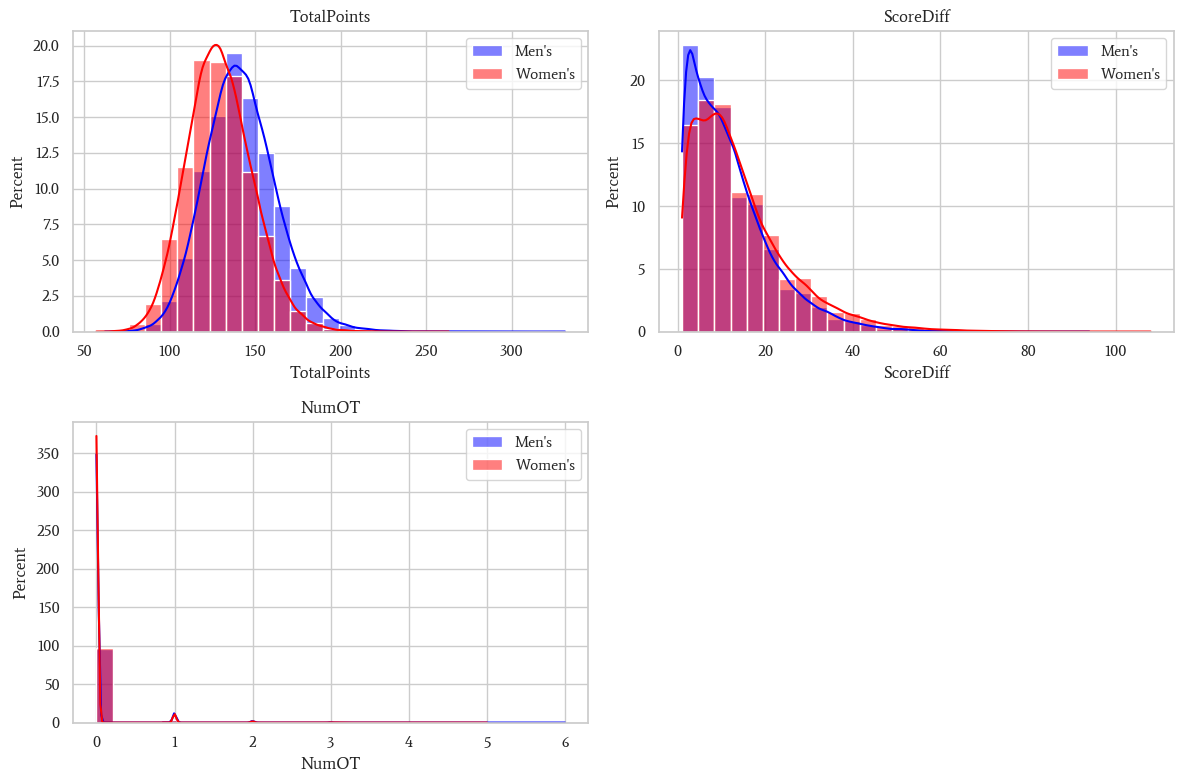

In [13]:
# plot overlapping histograms
plot_overlapping_histograms(df_mens, df_womens, columns=['TotalPoints', 'ScoreDiff', 'NumOT'])

- Men's games are generally higher scoring.
- Men's games have a higher frequency of being close (within 5 points).
- Women's games are more likely to result in blowouts. This could be due to women's programs being more top-heavy due to the smaller pool of women's players (a few schools recruit most of the best players).
- Overtime data is almost identical for both.

# Aggregate Statistics
The features will be mean (to capture average performance) and standard deviation (to capture consistency) of the point statistics and win-related information.

In [14]:
# aggregate stats
team_stats = aggregate_compact_stats(reg_results).fillna(0)

# check
team_stats.sample()

,Season,TeamID,num_games,win_pct,mean_pts,std_pts,mean_pts_against,std_pts_against,mean_score_diff,std_score_diff,home_game_pct,away_game_pct,neutral_game_pct,home_win_pct,away_win_pct,neutral_win_pct,close_games_pct,close_games_win_pct
14380,1990,1119,28,0.321429,69.035714,8.578535,74.714286,13.280052,-5.678571,11.508623,0.392857,0.428571,0.178571,0.636364,0.0,0.4,0.285714,0.5


In __team_stats__, each row is a single NCAA team's entire season containing aggregated team statistics. We have access to over 22k team seasons in NCAA basketball. Only 64 teams make the tournament each year, so most of the rows in this dataframe will not be part of the follwing merge.

# Location (Reg Season)

In [15]:
# look at winning percentages at different locations
display(df_mens.Loc.value_counts(normalize=True))
display(df_womens.Loc.value_counts(normalize=True))

Loc
H    0.590484
A    0.307091
N    0.102426
Name: proportion, dtype: float64

Loc
H    0.566257
A    0.359233
N    0.074510
Name: proportion, dtype: float64

- 59% of Men's regular season wins took place at home, almost double that of away wins (31%)
- Women's home advantage was a bit less severe, only showing a 57% home-court advantage to an away win-rate of 36%.

# Save 2025 Features
For the remainder of the notebook, we'll be analyzing tournament results (which we don't yet have for 2025). Well save the aggregated regular season statistics and then use them again at the end of the [Predictions Notebook](./preds_compact.ipynb).

In [16]:
# save 2025 features
features_2025 = team_stats.query('Season == 2025').drop(columns='Season')
features_2025.to_csv('data/cleaned/features_2025_compact.csv', index=False)

# Seeding
We now need to merge the tourney_results table (the one that contains seeding data) with reg_results. We will apply all of the same transformations so that we can do this.

In [17]:
# create a seed map for current and opponent teams
seed_map = dict(zip(zip(seeds['Season'], seeds['TeamID']), seeds['Seed']))

# look at 2 unique play-in seeds (4 chars long)
list(set({k: v for k, v in seed_map.items() if len(v) == 4}.values()))[:2]

['Y12b', 'W16b']

Every seed value has a character (W, X, Y, Z) representing the 4 regions, as well as a number representing their seeding in that region. Play-in teams have a 4th letter (X11a, X12b). We will split this information and add it to the tourney_results table.

In [18]:
# add seeds
tourney_results['WSeed'] = tourney_results.apply(lambda row: seed_map.get((row['Season'], row['WTeamID'])), axis=1)
tourney_results['LSeed'] = tourney_results.apply(lambda row: seed_map.get((row['Season'], row['LTeamID'])), axis=1)

# split the seed value into region, seed num, and play-in flag
tourney_results[['WRegion', 'WSeed_num', 'WPlayIn']] = tourney_results['WSeed'].apply(split_seed).apply(pd.Series)
tourney_results[['LRegion', 'LSeed_num', 'LPlayIn']] = tourney_results['LSeed'].apply(split_seed).apply(pd.Series)

# drop any non-numeric chars from seed nums
tourney_results['WSeed_num'] = tourney_results['WSeed_num'].str.extract('(\d+)').astype(int).copy()
tourney_results['LSeed_num'] = tourney_results['LSeed_num'].str.extract('(\d+)').astype(int).copy()

# drop old seed cols and reorder
tourney_results = tourney_results[['Season', 'DayNum', 'WTeamID', 'WScore', 'WRegion', 'WSeed_num', 'WPlayIn', 'WLoc', 'LTeamID', 'LScore', 'LRegion', 'LSeed_num', 'LPlayIn', 'NumOT']]

# check
print(tourney_results.shape)
tourney_results.sample()

(4168, 14)


,Season,DayNum,WTeamID,WScore,WRegion,WSeed_num,WPlayIn,WLoc,LTeamID,LScore,LRegion,LSeed_num,LPlayIn,NumOT
2617,1999,139,3256,79,Z,1,0,H,3336,62,Z,8,0,0


In __tourney_results__, each row is a NCAA Tournament game. We have access to over 4000 games, which will effectively act as our labels.

In [19]:
# merge tourney_results with team_stats
master = tourney_results.merge(
    team_stats, 
    how='left', 
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']

).merge(
    team_stats, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
)

# add LLoc col
master['LLoc'] = master['WLoc'].apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')

# drop duplicate columns
master = master.T.drop_duplicates().T

# check
print(master.shape)
master.sample()

(4168, 47)


,Season,DayNum,WTeamID,WScore,WRegion,WSeed_num,WPlayIn,WLoc,LTeamID,LScore,LRegion,LSeed_num,LPlayIn,NumOT,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,home_game_pct_x,away_game_pct_x,neutral_game_pct_x,home_win_pct_x,away_win_pct_x,neutral_win_pct_x,close_games_pct_x,close_games_win_pct_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,home_game_pct_y,away_game_pct_y,neutral_game_pct_y,home_win_pct_y,away_win_pct_y,neutral_win_pct_y,close_games_pct_y,close_games_win_pct_y,LLoc
1601,2010,137,1143,77,X,8,0,N,1257,62,X,9,0,0,33,0.69697,77.969697,10.187262,68.393939,12.474823,9.575758,15.392836,0.484848,0.363636,0.151515,0.9375,0.5,0.4,0.060606,0.0,32,0.625,76.34375,12.116662,69.59375,11.774383,6.75,15.866378,0.59375,0.34375,0.0625,0.789474,0.363636,0.5,0.1875,0.333333,N


__master__ is our final dataframe, containing tournament matchups and aggregated statistics from each teams' regular season.

# Upsets
- In this section, we look at the number of upsets (underdog winning) in past NCAA brackets. 
- In this competition, we are only predicting the 63 bracket games, not the 4 play-in games. Due to this, we can drop the 4 losing play-in teams from our seeds table, leaving 64 teams.

In [20]:
# check num games for each season
master['Season'].value_counts().sort_index()

Season
1985     63
1986     63
1987     63
1988     63
1989     63
1990     63
1991     63
1992     63
1993     63
1994     63
1995     63
1996     63
1997     63
1998    126
1999    126
2000    126
2001    127
2002    127
2003    127
2004    127
2005    127
2006    127
2007    127
2008    127
2009    127
2010    127
2011    130
2012    130
2013    130
2014    130
2015    130
2016    130
2017    130
2018    130
2019    130
2021    129
2022    134
2023    134
2024    134
Name: count, dtype: int64

Here's our tournament data:
- 1985-1997: __63__ Men's games only (No women's or play-in games)
- 1998-2000: __126__ total games (women's tournament was added)
- 2001-2010: __127__ games (a single men's play-in game was added)
- 2011-2019: __130__ games (went from 1 to 4 men's play-in games)
- 2020: __0__ games (COVID, no tourney)
- 2021: __129__ games (VCU forfeits in round 1 to Oregon due to positive COVID tests)
- 2022-2024: __134__ games (4 women's play in games were added)

In [21]:
# drop play-in games
master = master.drop(master.query('WPlayIn == 1 & LPlayIn == 1').index)

# create seed diff cols
master['Wseed_diff'] = master['WSeed_num'] - master['LSeed_num']
master['Lseed_diff'] = master['Wseed_diff'] * -1

# assign tournament round
master = assign_tournament_round(master)

# split genders
df_mens, df_womens = split_genders(master, id_col='WTeamID')

# check
print(df_mens.shape, df_womens.shape)
display(df_mens.sample())
display(df_womens.sample())

(2456, 50) (1638, 50)


,Season,DayNum,WTeamID,WScore,WRegion,WSeed_num,WPlayIn,WLoc,LTeamID,LScore,LRegion,LSeed_num,LPlayIn,NumOT,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,home_game_pct_x,away_game_pct_x,neutral_game_pct_x,home_win_pct_x,away_win_pct_x,neutral_win_pct_x,close_games_pct_x,close_games_win_pct_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,home_game_pct_y,away_game_pct_y,neutral_game_pct_y,home_win_pct_y,away_win_pct_y,neutral_win_pct_y,close_games_pct_y,close_games_win_pct_y,LLoc,Wseed_diff,Lseed_diff,round
45,1985,139,1272,67,Y,2,0,N,1412,66,Y,7,0,1,29,0.896552,75.137931,11.633462,64.689655,10.22987,10.448276,8.487748,0.482759,0.448276,0.068966,1.0,0.769231,1.0,0.137931,0.75,30,0.733333,66.033333,8.070736,61.7,7.34448,4.333333,8.615677,0.5,0.266667,0.233333,0.8,0.625,0.714286,0.333333,0.5,N,-5,5,2


,Season,DayNum,WTeamID,WScore,WRegion,WSeed_num,WPlayIn,WLoc,LTeamID,LScore,LRegion,LSeed_num,LPlayIn,NumOT,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,home_game_pct_x,away_game_pct_x,neutral_game_pct_x,home_win_pct_x,away_win_pct_x,neutral_win_pct_x,close_games_pct_x,close_games_win_pct_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,home_game_pct_y,away_game_pct_y,neutral_game_pct_y,home_win_pct_y,away_win_pct_y,neutral_win_pct_y,close_games_pct_y,close_games_win_pct_y,LLoc,Wseed_diff,Lseed_diff,round
1168,2016,139,3280,74,W,5,0,A,3277,72,W,4,0,0,33,0.787879,70.242424,16.465931,54.30303,11.988236,15.939394,23.089418,0.484848,0.30303,0.212121,0.875,0.6,0.857143,0.060606,1.0,32,0.75,76.09375,13.332859,64.28125,17.122395,11.8125,15.936239,0.46875,0.375,0.15625,0.866667,0.666667,0.6,0.09375,1.0,H,1,-1,2


## Men

In [22]:
# categorize games based on seed differences
df_mens['Game Category'] = df_mens['Wseed_diff'].apply(lambda x: 'Favorite Wins' if x < 0 else 'Upsets' if x > 0 else 'Equal Seeds')

# show results
df_mens['Game Category'].value_counts(normalize=True)

Game Category
Favorite Wins    0.705619
Upsets           0.282980
Equal Seeds      0.011401
Name: proportion, dtype: float64

- Very few bracket games occur between equal seeds (1%), as this can only happen in the final four and championship games.

In [23]:
# drop equal seed games
df_mens = df_mens.query('Wseed_diff != 0')

# show results
df_mens['Game Category'].value_counts(normalize=True)

Game Category
Favorite Wins    0.713756
Upsets           0.286244
Name: proportion, dtype: float64

- We can see that the better seed wins the majority of the time (71%).
- Upset wins (lower seed winning) occurrs about 28% of the time.

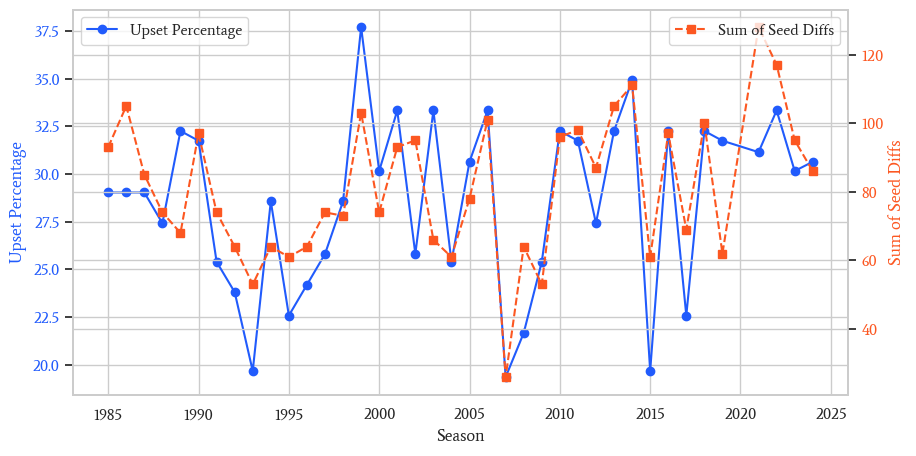

,count,mean,std,min,25%,50%,75%,max
Upset_Percentage,39.0,28.606525,4.54888,19.354839,25.396825,29.032258,32.258065,37.704918


,count,mean,std,min,25%,50%,75%,max
Upset_Sum,39.0,81.410256,20.960763,26.0,64.0,78.0,97.0,128.0


In [24]:
# normalize weights per season
upset_by_year = df_mens.groupby('Season').agg(
    Total_Games=('Game Category', 'count'),
    Upset_Games=('Wseed_diff', lambda x: (x > 0).sum()),
    Upset_Sum=('Wseed_diff', lambda x: x[x > 0].sum())
).reset_index()

# add upset percentage
upset_by_year['Upset_Percentage'] = upset_by_year['Upset_Games'] / upset_by_year['Total_Games'] * 100

# plot upset percentage
plot_upset_percentage(upset_by_year, 'Season')

# describe
display(upset_by_year[['Upset_Percentage']].describe().T)
display(upset_by_year[['Upset_Sum']].describe().T)

- 19% - 37% of tournament games have resulted in an upset (lower seed winning), with an average of 28%. Upset percantage has been north of 30% for the last 6 seasons.
- Upset sum (sum of seed differentials) generally correlates with upset frequency. It has recorded its 2 maximum values in the last 4 seasons.

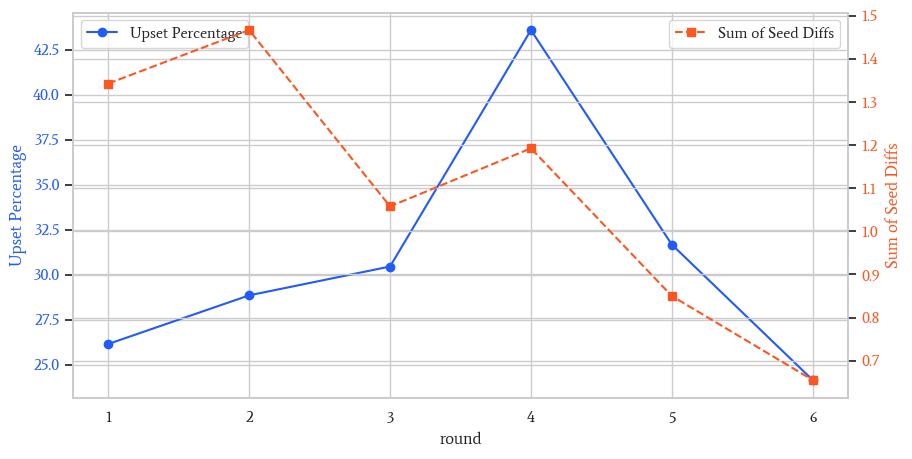

,round,Total_Games,Upset_Games,Upset_Sum,Upset_Percentage
0,1,1247,326,1.342422,26.142743
1,2,624,180,1.466346,28.846154
2,3,312,95,1.057692,30.448718
3,4,156,68,1.192308,43.589744
4,5,60,19,0.850000,31.666667
5,6,29,7,0.655172,24.137931


In [25]:
# normalize weights per season & round
upset_by_round = df_mens.groupby(['round']).agg(
    Total_Games=('Game Category', 'count'),
    Upset_Games=('Wseed_diff', lambda x: (x > 0).sum()),
    Upset_Sum=('Wseed_diff', lambda x: x[x > 0].sum())
).reset_index()

# add upset percentage
upset_by_round['Upset_Percentage'] = upset_by_round['Upset_Games'] / upset_by_round['Total_Games'] * 100

# normalize Upset_Sum (average seed diff per game in round)
upset_by_round['Upset_Sum'] = upset_by_round['Upset_Sum'] / upset_by_round['Total_Games']

# plot upset percentage
plot_upset_percentage(upset_by_round, 'round')

# show
upset_by_round

- Normalized upset sum sharply decreases after rounds 1 and 2.
- Upset percentage spikes in round 4 (Elite 8), where many of the teams are close in seeding.

## Women

In [26]:
# categorize games based on seed differences
df_womens['Game Category'] = df_womens['Wseed_diff'].apply(lambda x: 'Favorite Wins' if x < 0 else 'Upsets' if x > 0 else 'Equal Seeds')

# drop equal seed games
df_womens = df_womens.query('Wseed_diff != 0')

# show results
df_womens['Game Category'].value_counts(normalize=True)

Game Category
Favorite Wins    0.781366
Upsets           0.218634
Name: proportion, dtype: float64

- The favorite wins even more often in the Women's bracket (78%).
- Upset wins are more rare (only 21%).

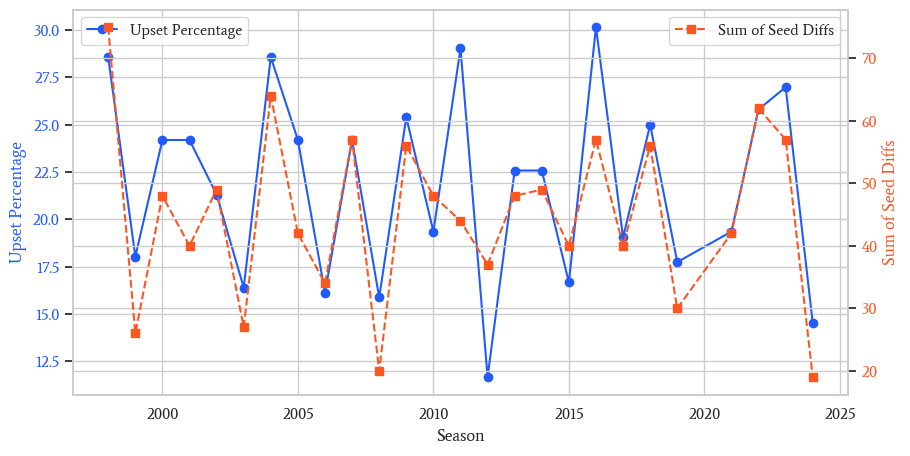

,count,mean,std,min,25%,50%,75%,max
Upset_Percentage,26.0,21.828661,5.032447,11.666667,17.814648,22.580645,25.297619,30.15873


,count,mean,std,min,25%,50%,75%,max
Upset_Sum,26.0,44.884615,13.816879,19.0,37.75,46.0,56.0,75.0


In [27]:
# normalize weights per season (drop equal seeds)
upset_by_year = df_womens.groupby('Season').agg(
    Total_Games=('Game Category', 'count'),
    Upset_Games=('Wseed_diff', lambda x: (x > 0).sum()),
    Upset_Sum=('Wseed_diff', lambda x: x[x > 0].sum())
).reset_index()

# add upset percentage
upset_by_year['Upset_Percentage'] = upset_by_year['Upset_Games'] / upset_by_year['Total_Games'] * 100

# plot upset percentage
plot_upset_percentage(upset_by_year, 'Season')

# describe
display(upset_by_year[['Upset_Percentage']].describe().T)
display(upset_by_year[['Upset_Sum']].describe().T)

- 11% - 30% of tournament games have resulted in an upset win, with an average of 21%. Upset percantage reached its second lowest value in 2024.
- However, upset sum has still recorded 2 very high values recently (2022, 2023).

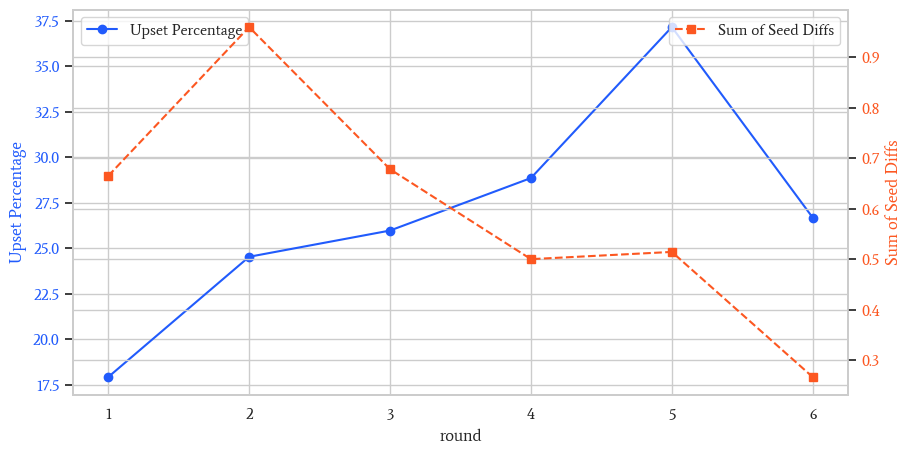

,round,Total_Games,Upset_Games,Upset_Sum,Upset_Percentage
0,1,832,149,0.664663,17.908654
1,2,416,102,0.959135,24.519231
2,3,208,54,0.677885,25.961538
3,4,104,30,0.500000,28.846154
4,5,35,13,0.514286,37.142857
5,6,15,4,0.266667,26.666667


In [28]:
# normalize weights per season & round
upset_by_round = df_womens.groupby(['round']).agg(
    Total_Games=('Game Category', 'count'),
    Upset_Games=('Wseed_diff', lambda x: (x > 0).sum()),
    Upset_Sum=('Wseed_diff', lambda x: x[x > 0].sum())
).reset_index()

# add upset percentage
upset_by_round['Upset_Percentage'] = upset_by_round['Upset_Games'] / upset_by_round['Total_Games'] * 100

# normalize Upset_Sum (average seed diff per game in round)
upset_by_round['Upset_Sum'] = upset_by_round['Upset_Sum'] / upset_by_round['Total_Games']

# plot upset percentage
plot_upset_percentage(upset_by_round, 'round')

# show
upset_by_round

- Normalized upset sum sharply decreases after round 2.
- Upset percentage spikes in round 5 (Final Four).
- Compared to men's, upsets are significantly less common in rounds 1 and 4 for the women's tournament, moderately less common for rounds 2 and 3, and slightly more common in rounds 5 and 6.

# Past Champions

In [29]:
# team names
team_map = pd.concat([pd.read_csv(MENS_ROOT + 'MTeams.csv'), pd.read_csv(WOMENS_ROOT + 'WTeams.csv')], ignore_index=True).set_index('TeamID')['TeamName']

# map to master
master['WTeamName'] = master['WTeamID'].map(team_map)
master['LTeamName'] = master['LTeamID'].map(team_map)

# check
master[['WTeamName', 'LTeamName']].sample()

,WTeamName,LTeamName
736,Georgia Tech,Boston College


In [30]:
# count WTeamID where round is 6
finals = master.query('round == 6')['WTeamID'].value_counts()

# create championship column
master['Wnum_championships'] = master['WTeamID'].map(finals).fillna(0).astype(int)
master['Lnum_championships'] = master['LTeamID'].map(finals).fillna(0).astype(int)

# split genders
df_mens, df_womens = split_genders(master, 'WTeamID')

# look at mens and womens teams with the most championships
print('Mens Teams with Most Championships:')
display(df_mens.query('round == 6')[['WTeamName', 'Wnum_championships']].drop_duplicates().sort_values('Wnum_championships', ascending=False).T)
print('Womens Teams with Most Championships:')
display(df_womens.query('round == 6')[['WTeamName', 'Wnum_championships']].drop_duplicates().sort_values('Wnum_championships', ascending=False).T)

Mens Teams with Most Championships:


,944,440,566,62,251,755,1385,125,2204,1196,1133,1007,692,818,629,377,314,188,2266
WTeamName,Connecticut,Duke,North Carolina,Villanova,Kansas,Kentucky,Florida,Louisville,Virginia,Syracuse,Maryland,Michigan St,UCLA,Arizona,Arkansas,UNLV,Michigan,Indiana,Baylor
Wnum_championships,6,5,4,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1


Womens Teams with Most Championships:


,188,62,503,1259,251,125,566,881,1448,1574
WTeamName,Connecticut,Tennessee,Baylor,South Carolina,Notre Dame,Purdue,Maryland,Texas A&M,Stanford,LSU
Wnum_championships,10,3,3,3,2,1,1,1,1,1


- 19 unique men's programs have won the championship in the last 39 seasons. Keep in mind, we are missing the first 46 seasons (1939-1984).
- 10 unique men's programs have won the championship over 26 seasons. UConn has won 38.5% (10/26) of the women's tournaments. Talk about a dynasty.

# Undefeated Teams

In [31]:
master

,Season,DayNum,WTeamID,WScore,WRegion,WSeed_num,WPlayIn,WLoc,LTeamID,LScore,LRegion,LSeed_num,LPlayIn,NumOT,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,home_game_pct_x,away_game_pct_x,neutral_game_pct_x,home_win_pct_x,away_win_pct_x,neutral_win_pct_x,close_games_pct_x,close_games_win_pct_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,home_game_pct_y,away_game_pct_y,neutral_game_pct_y,home_win_pct_y,away_win_pct_y,neutral_win_pct_y,close_games_pct_y,close_games_win_pct_y,LLoc,Wseed_diff,Lseed_diff,round,WTeamName,LTeamName,Wnum_championships,Lnum_championships
0,1985,136,1116,63,X,9,0,N,1234,54,X,8,0,0,33,0.636364,65.333333,12.151817,61.69697,9.815437,3.636364,11.661417,0.333333,0.363636,0.30303,0.909091,0.333333,0.7,0.272727,0.333333,30,0.666667,69.733333,15.418156,59.266667,11.295203,10.466667,16.074682,0.6,0.3,0.1,0.833333,0.333333,0.666667,0.166667,0.2,N,1,-1,1,Arkansas,Iowa,1,0
1,1985,136,1120,59,Z,11,0,N,1345,58,Z,6,0,0,29,0.62069,70.344828,13.649374,66.655172,13.594316,3.689655,14.757815,0.413793,0.37931,0.206897,0.666667,0.454545,0.833333,0.344828,0.7,25,0.68,69.12,10.365488,65.32,14.47043,3.8,16.140012,0.56,0.4,0.04,0.714286,0.6,1.0,0.08,1.0,N,5,-5,1,Auburn,Purdue,0,0
2,1985,136,1207,68,W,1,0,N,1250,43,W,16,0,0,27,0.925926,75.740741,11.944077,60.074074,10.622639,15.666667,10.845063,0.481481,0.259259,0.259259,0.923077,0.857143,1.0,0.148148,0.5,29,0.37931,65.758621,10.692638,70.206897,8.453145,-4.448276,12.069993,0.413793,0.37931,0.206897,0.333333,0.363636,0.5,0.37931,0.454545,N,-15,15,1,Georgetown,Lehigh,0,0
3,1985,136,1229,58,Y,9,0,N,1425,55,Y,8,0,0,27,0.740741,71.592593,11.304387,65.62963,11.419107,5.962963,11.85321,0.518519,0.37037,0.111111,0.785714,0.6,1.0,0.185185,0.8,28,0.678571,68.392857,11.324635,64.607143,8.731973,3.785714,11.631239,0.5,0.392857,0.107143,0.642857,0.727273,0.666667,0.321429,0.666667,N,1,-1,1,Illinois St,USC,0,0
4,1985,136,1242,49,Z,3,0,N,1325,38,Z,14,0,0,30,0.766667,76.033333,11.201857,70.4,11.336849,5.633333,10.60736,0.466667,0.333333,0.2,1.0,0.6,0.5,0.166667,0.6,27,0.740741,67.555556,9.528634,63.0,11.432074,4.555556,9.32463,0.37037,0.444444,0.185185,1.0,0.583333,0.6,0.148148,0.75,N,-11,11,1,Kansas,Ohio,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,2024,147,3163,80,Z,3,0,A,3425,73,Z,1,0,0,33,0.848485,79.878788,11.575182,56.969697,14.687335,22.909091,18.279708,0.424242,0.393939,0.181818,0.928571,0.769231,0.833333,0.0,0.0,31,0.83871,74.677419,11.720032,62.16129,11.764627,12.516129,16.249864,0.483871,0.322581,0.193548,0.866667,0.7,1.0,0.16129,0.8,H,2,-2,4,Connecticut,USC,10,0
4090,2024,147,3234,94,Y,1,0,H,3261,87,Y,3,0,0,33,0.878788,92.848485,13.041092,71.909091,13.175175,20.939394,17.430109,0.424242,0.333333,0.242424,0.928571,0.727273,1.0,0.121212,0.5,33,0.848485,86.69697,15.84788,62.545455,12.15805,24.151515,22.164331,0.515152,0.30303,0.181818,0.941176,0.8,0.666667,0.030303,1.0,A,-2,2,4,Iowa,LSU,0,1
4091,2024,151,3234,71,Y,1,0,N,3163,69,Z,3,0,0,33,0.878788,92.848485,13.041092,71.909091,13.175175,20.939394,17.430109,0.424242,0.333333,0.242424,0.928571,0.727273,1.0,0.121212,0.5,33,0.848485,79.878788,11.575182,56.969697,14.687335,22.909091,18.279708,0.424242,0.393939,0.181818,0.928571,0.769231,0.833333,0.0,0.0,N,-2,2,5,Iowa,Connecticut,0,10
4092,2024,151,3376,78,W,1,0,N,3301,59,X,3,0,0,32,1.0,86.0625,13.092567,56.3125,14.649535,29.75,21.23752,0.46875,0.375,0.15625,1.0,1.0,1.0,0.03125,1.0,33,0.818182,73.818182,11.40574,60.0,12.283118,13.818182,16.115704,0.484848,0.333333,0.181818,0.9375,0.636364,0.833333,0.151515,0.8,N,-2,2,5,South Carolina,NC State,3,0


In [32]:
# undefeated seasons
undefeated = team_stats.query('win_pct == 1')

# split genders
undefeated_mens, undefeated_womens = split_genders(undefeated, 'TeamID')

undefeated_mens.shape, undefeated_womens.shape

((4, 18), (16, 18))

- There have been 20 undefeated seasons since 1985 (16 women's, only 4 men's). Let's see how they performed in the tournament.

In [33]:
# get undefeated teams (Season and TeamID)
undefeated_teams = undefeated[['Season', 'TeamID']]

# get games where undefeated team won
undefeated_games_wins = undefeated_teams.merge(
    master[['Season', 'WTeamID', 'LTeamID', 'WTeamName', 'LTeamName', 'round']], 
    how='left', 
    left_on=['Season', 'TeamID'], 
    right_on=['Season', 'WTeamID'],
    suffixes=('', '_win')
)

# get games where undefeated team lost
undefeated_games_losses = undefeated_teams.merge(
    master[['Season', 'WTeamID', 'LTeamID', 'WTeamName', 'LTeamName', 'round']], 
    how='left', 
    left_on=['Season', 'TeamID'], 
    right_on=['Season', 'LTeamID'],
    suffixes=('', '_loss')
)

# concatenate the win and loss games
undefeated_games = pd.concat([undefeated_games_wins, undefeated_games_losses]).sort_values(['Season', 'TeamID'])

# drop rows where both win and loss columns are NaN (team did not lose a game in the tournament; won championship)
undefeated_games = undefeated_games.dropna(subset=['WTeamID', 'LTeamID'], how='all')

# show W-L record for undefeated teams in the tournament
undefeated_games_wins.shape[0], undefeated_games_losses.shape[0]

(83, 20)

- Undefeated teams have gone 83-20 in the NCAA tournament (average losing in Final Four).

In [34]:
# times where an undefeated team lost in second round or earlier
undefeated_games.query('(round <= 2) & (LTeamID == TeamID)')

,Season,TeamID,WTeamID,LTeamID,WTeamName,LTeamName,round
2,1998,3251,3397,3251,Tennessee,Liberty,1.0
8,1998,3464,3301,3464,NC State,Youngstown St,2.0
6,2014,1455,1246,1455,Kentucky,Wichita St,2.0
16,2015,3343,3268,3343,Maryland,Princeton,2.0


- Only 4/20 undefeated teams have lost in the first or second rounds.
- 1998 Women's Liberty is the only 1 of 20 undefeated teams to lose in the first round.

In [35]:
# times where an undefeated team won the championship
undefeated_games.query('round == 6 & (WTeamID == TeamID)')

,Season,TeamID,WTeamID,LTeamID,WTeamName,LTeamName,round
58,1998,3397,3397,3256,Tennessee,Louisiana Tech,6.0
70,2002,3163,3163,3328,Connecticut,Oklahoma,6.0
39,2009,3163,3163,3257,Connecticut,Louisville,6.0
82,2010,3163,3163,3390,Connecticut,Stanford,6.0
27,2012,3124,3124,3323,Baylor,Notre Dame,6.0
21,2014,3163,3163,3323,Connecticut,Notre Dame,6.0
76,2016,3163,3163,3393,Connecticut,Syracuse,6.0
9,2024,3376,3376,3234,South Carolina,Iowa,6.0


- 8/16 undefeated women's teams have gone on to win the chamionship.
- UConn was 5 of these.

In [36]:
# times where an undefeated team lost the championship
undefeated_games.query('round == 6 & (LTeamID == TeamID)')

,Season,TeamID,WTeamID,LTeamID,WTeamName,LTeamName,round
15,2014,3323,3163,3323,Connecticut,Notre Dame,6.0
3,2021,1211,1124,1211,Baylor,Gonzaga,6.0


- 2 undefeated teams have lost the chamionship.
- The only undefeated men's team to make the title is 2021 Gonzaga, where they lost to Baylor.

# Play-In Teams

In [37]:
# get play-in team rows
playin_teams = master.query('(WPlayIn == 1) | (LPlayIn == 1)')

# split genders
playin_mens, playin_womens = split_genders(playin_teams, 'WTeamID')

# show counts and accuracy
win_pct_mens = (playin_mens.query('WPlayIn == 1').shape[0] / playin_mens.shape[0]) * 100
print(f"Men's Play-in team Win % ({playin_mens.shape[0]} games): {win_pct_mens:.2f}%")
win_pct_womens = (playin_womens.query('WPlayIn == 1').shape[0] / playin_womens.shape[0]) * 100
print(f"Women's Play-in team Win % ({playin_womens.shape[0]} games): {win_pct_womens:.2f}%")

Men's Play-in team Win % (84 games): 26.19%
Women's Play-in team Win % (13 games): 7.69%


- Men's play-in teams only win 26% of their games. This means that on average per tourney only one of the 4 play-in teams wins a single game.
- Women's are much more rare, only winning 7% of the time. However, play-in games were only added in 2022 for women, a small sample size.

In [38]:
# farthest a play-in team has gone
playin_mens.query('round > 3')[['Season', 'WTeamName', 'LTeamName', 'WPlayIn', 'LPlayIn', 'round']].sort_values('round')

,Season,WTeamName,LTeamName,WPlayIn,LPlayIn,round
16,2011,VCU,Kansas,1,0,4
66,2021,UCLA,Michigan,1,0,4
17,2011,Butler,VCU,0,1,5
67,2021,Gonzaga,UCLA,0,1,5


- Only 2 times has a men's play-in team made it to the elite 8 (2011 VCU and 2021 UCLA), and in both of these instances, the team also advanced to the final 4, but then lost.

In [39]:
# women's
playin_womens.query('round > 1')[['Season', 'WTeamName', 'LTeamName', 'WPlayIn', 'LPlayIn', 'round']].sort_values('round')

,Season,WTeamName,LTeamName,WPlayIn,LPlayIn,round
8,2023,Notre Dame,Mississippi St,0,1,2


- Only 1 women's play in team has won a single game, and they were quickly eliminated in round 2.

# Tournament Location

In [40]:
# look at game locations
display(df_mens['WLoc'].value_counts())
display(df_womens['WLoc'].value_counts())

WLoc
N    2456
Name: count, dtype: int64

WLoc
N    841
H    648
A    149
Name: count, dtype: int64

- All men's games are played at a neutral site.
- Only about half of women's games are played at a neutral site. 

In [41]:
# create 'Loc_Type' column
df_womens['Loc_Type'] = df_womens['WLoc'].apply(lambda x: 'Neutral' if x == 'N' else 'Non-Neutral')

# check
df_womens[df_womens['round'] <= 2]['Loc_Type'].value_counts()

Loc_Type
Non-Neutral    719
Neutral        529
Name: count, dtype: int64

- Most of these non-neutral site games are played in the first 2 rounds.

# Save Data

In [42]:
# save to csv
master.to_csv('data/cleaned/features_compact.csv', index=False)